In [1]:
import numpy as np
from numpy import array
import pandas as pd
import re
import string as str

import urllib.request
from bs4 import BeautifulSoup

import spacy
import nltk
from spacy.matcher import Matcher 
from spacy.tokens import Span 
from nltk.tokenize import word_tokenize
from nltk.tag import pos_tag
from nltk.chunk import conlltags2tree, tree2conlltags

from nltk.corpus import stopwords                   # Stopwords corpus
from nltk.stem import PorterStemmer                 # Stemmer
from nltk.stem import WordNetLemmatizer             # WordNet

from sklearn.feature_extraction.text import CountVectorizer          #For Bag of words
from sklearn.feature_extraction.text import TfidfVectorizer          #For TF-IDF
from gensim.models import Word2Vec                                   #For Word2Vec

from pprint import pprint
from collections import Counter
from tqdm import tqdm

import networkx as nx
import matplotlib.pyplot as plt

In [4]:
def url_to_string(url):
    #res = requests.get(url)
    #html = res.text
    html = urllib.request.urlopen(url)
    
    soup = BeautifulSoup(html, 'html.parser')
    
    # kill all script, style and other elements
    for script in soup(['script', 'style', 'button', 'a']):
        script.extract()

    # get text
    text = soup.get_text()
        
    # break into lines and remove leading and trailing space on each
    lines = [line.strip() for line in text.splitlines()]
    # break multi-headlines into a line each
    chunks = [phrase.strip() for line in lines for phrase in line.split("  ")]
    # drop blank lines
    text = '\n'.join([chunk for chunk in chunks if chunk])
    
    return text
url = 'https://insights.hsbc.co.uk/content/hsbc/gb/en_gb/wealth/insights/macro-outlook/china-insights/china-insights-2019-09-11/'
text = url_to_string(url)
print(text)

China Insights – HSBC Insights
We use cookies
We use cookies to give you the best possible experience on our website. By continuing to browse this site, you give consent for cookies to be used. For more details, please read our Cookie Policy.
.
Language
English
Everyday banking
Accounts & services
Borrowing
Loans & mortgages
Investing
Products & planning
Insurance
Property & family
Help
Support & security
Everyday banking
Accounts & services
Borrowing
Loans & mortgages
Investing
Products & planning
Insurance
Property & family
Help
Support & security
UK
Language
English
Language
Top of main content
China Insights
|
Monthly update on Chinese markets
11/09/2019
This article is about
Equities
China
Summary
China’s property prices have continued to rise so far this year, shrugging off worries about a slowing economy
and prolonged trade conflicts with the US
However, soaring prices have complicated efforts to spur growth as policy makers monitor downside risks
New interest rate benchmark sho

In [5]:
df = pd.DataFrame({'Sentences':text.split('\n')})
df

,Sentences
0,China Insights – HSBC Insights
1,We use cookies
2,We use cookies to give you the best possible e...
3,.
4,Language
...,...
109,Help & support
110,Branch Finder
111,Our Service performance
112,About HSBC


In [6]:
train_df = df[44:106]
train_df.reset_index(drop=True, inplace=True)
train_df

,Sentences
0,China Property: A balancing act between growth...
1,China’s property prices have continued to rise...
2,"There are, however, signs that policymakers wa..."
3,"The National Development Reform Commission, th..."
4,The recent tightening in overseas funding chan...
...,...
57,This document is prepared by or on behalf of H...
58,This document is not prepared with any particu...
59,You should consult a professional adviser in y...
60,"No part of this document may be reproduced, st..."


In [7]:
# list of sentences
segment = []
for text in train_df['Sentences']:
    segment.append(re.split('[^0-9]["."][^0-9]', text))

sentences = [sent for sents in segment for sent in sents]
#sentences.sort()
sentences

['China Property: A balancing act between growth and reforms',
 'China’s property prices have continued to rise so far this year despite a prolonged trade conflict with the US.',
 'There are, however, signs that policymakers want to keep the runaway prices under control, with new tightening measures to rein in credit for both developers and homebuyers.',
 'The National Development Reform Commission, the country’s top economic planner, in July tightened the grip on the issuance of offshore debt, curtailing developers’ appetite for new debt issuanc',
 'Specifically, developers can only issue debt to refinance outstanding foreign-currency liabilities in the next 12 months, a move intended to cool land market auctions in the country.',
 'The recent tightening in overseas funding channels, mainly the offshore US dollar credit market, has followed the reining in of the trust financing channel in the onshore market, another major source of funding channel for the capital-intensive industry.',

In [8]:
# Tune some sentences in the passage
sentences[13] = ' '.join(sentences[13:16])
sentences.pop(15)
sentences.pop(14)
sentences

['China Property: A balancing act between growth and reforms',
 'China’s property prices have continued to rise so far this year despite a prolonged trade conflict with the US.',
 'There are, however, signs that policymakers want to keep the runaway prices under control, with new tightening measures to rein in credit for both developers and homebuyers.',
 'The National Development Reform Commission, the country’s top economic planner, in July tightened the grip on the issuance of offshore debt, curtailing developers’ appetite for new debt issuanc',
 'Specifically, developers can only issue debt to refinance outstanding foreign-currency liabilities in the next 12 months, a move intended to cool land market auctions in the country.',
 'The recent tightening in overseas funding channels, mainly the offshore US dollar credit market, has followed the reining in of the trust financing channel in the onshore market, another major source of funding channel for the capital-intensive industry.',

In [9]:
def preprocess(sentences):
    list_of_words = []
    for sent in sentences:
        # Convert all words to lowercase
        sent = sent.lower()

        # Remove numbers
        # sent = re.sub(r'\d+', '', sent)

        # Remove punctuation
        #sent = sent.translate(string.maketrans(','), string.punctuation)

        # Remove space
        sent = sent.strip()

        # Remove stop-words and Stemming
        stop_words = set(stopwords.words('english'))
        tokens = nltk.word_tokenize(sent)
        tokens_ = [i for i in tokens if not i in stop_words]
        
        stemmer = PorterStemmer()
        for token in tokens_:
            stems = stemmer.stem(token)
            list_of_words.append(stems)

        # Lemmatization with WordNet
    #    lemmatizer = WordNetLemmatizer()
    #    words = [lemmatizer.lemmatize(word) for word in text.split() if word not in stop_words]
    
        #list_of_words.append(words)

    return list_of_words
list_of_words = preprocess(sentences)
list_of_words

['china',
 'properti',
 ':',
 'balanc',
 'act',
 'growth',
 'reform',
 'china',
 '’',
 'properti',
 'price',
 'continu',
 'rise',
 'far',
 'year',
 'despit',
 'prolong',
 'trade',
 'conflict',
 'us',
 '.',
 ',',
 'howev',
 ',',
 'sign',
 'policymak',
 'want',
 'keep',
 'runaway',
 'price',
 'control',
 ',',
 'new',
 'tighten',
 'measur',
 'rein',
 'credit',
 'develop',
 'homebuy',
 '.',
 'nation',
 'develop',
 'reform',
 'commiss',
 ',',
 'countri',
 '’',
 'top',
 'econom',
 'planner',
 ',',
 'juli',
 'tighten',
 'grip',
 'issuanc',
 'offshor',
 'debt',
 ',',
 'curtail',
 'develop',
 '’',
 'appetit',
 'new',
 'debt',
 'issuanc',
 'specif',
 ',',
 'develop',
 'issu',
 'debt',
 'refin',
 'outstand',
 'foreign-curr',
 'liabil',
 'next',
 '12',
 'month',
 ',',
 'move',
 'intend',
 'cool',
 'land',
 'market',
 'auction',
 'countri',
 '.',
 'recent',
 'tighten',
 'oversea',
 'fund',
 'channel',
 ',',
 'mainli',
 'offshor',
 'us',
 'dollar',
 'credit',
 'market',
 ',',
 'follow',
 'rein',
 't

In [10]:
# POS tagging (input: list of words)
POS = nltk.pos_tag(list_of_words)

# Chunking
pattern = 'NP: {<DT>?<JJ>*<NN>}'

NPChunker = nltk.RegexpParser(pattern)
result = NPChunker.parse(POS)
print(result)
#result.draw()

(S
  (NP china/NN)
  (NP properti/NN)
  :/:
  (NP balanc/NN)
  (NP act/NN)
  (NP growth/NN)
  (NP reform/NN)
  (NP china/NN)
  ’/NNP
  (NP properti/NN)
  (NP price/NN)
  continu/NNS
  (NP rise/NN)
  far/RB
  (NP year/NN)
  (NP despit/NN)
  prolong/IN
  (NP trade/NN)
  (NP conflict/NN)
  us/PRP
  ./.
  ,/,
  (NP howev/NN)
  ,/,
  (NP sign/NN)
  (NP policymak/NN)
  want/VBP
  keep/VB
  (NP runaway/JJ price/NN)
  (NP control/NN)
  ,/,
  (NP new/JJ tighten/JJ measur/NN)
  (NP rein/NN)
  (NP credit/NN)
  develop/VB
  (NP homebuy/NN)
  ./.
  (NP nation/NN)
  develop/VB
  (NP reform/NN)
  (NP commiss/NN)
  ,/,
  countri/JJ
  ’/NNP
  (NP top/NN)
  (NP econom/NN)
  (NP planner/NN)
  ,/,
  (NP juli/NN)
  (NP tighten/JJ grip/NN)
  (NP issuanc/NN)
  (NP offshor/NN)
  (NP debt/NN)
  ,/,
  (NP curtail/NN)
  (NP develop/NN)
  ’/NNP
  appetit/VBZ
  (NP new/JJ debt/NN)
  (NP issuanc/NN)
  (NP specif/NN)
  ,/,
  develop/VB
  (NP issu/JJ debt/NN)
  (NP refin/NN)
  outstand/IN
  (NP foreign-curr/JJ liabil

In [11]:
# Named Entities Recognition
ne_tree = nltk.ne_chunk(POS)
print(ne_tree)

(S
  china/NN
  properti/NN
  :/:
  balanc/NN
  act/NN
  growth/NN
  reform/NN
  china/NN
  ’/NNP
  properti/NN
  price/NN
  continu/NNS
  rise/NN
  far/RB
  year/NN
  despit/NN
  prolong/IN
  trade/NN
  conflict/NN
  us/PRP
  ./.
  ,/,
  howev/NN
  ,/,
  sign/NN
  policymak/NN
  want/VBP
  keep/VB
  runaway/JJ
  price/NN
  control/NN
  ,/,
  new/JJ
  tighten/JJ
  measur/NN
  rein/NN
  credit/NN
  develop/VB
  homebuy/NN
  ./.
  nation/NN
  develop/VB
  reform/NN
  commiss/NN
  ,/,
  countri/JJ
  ’/NNP
  top/NN
  econom/NN
  planner/NN
  ,/,
  juli/NN
  tighten/JJ
  grip/NN
  issuanc/NN
  offshor/NN
  debt/NN
  ,/,
  curtail/NN
  develop/NN
  ’/NNP
  appetit/VBZ
  new/JJ
  debt/NN
  issuanc/NN
  specif/NN
  ,/,
  develop/VB
  issu/JJ
  debt/NN
  refin/NN
  outstand/IN
  foreign-curr/JJ
  liabil/NN
  next/JJ
  12/CD
  month/NN
  ,/,
  move/VBP
  intend/NN
  cool/NN
  land/NN
  market/NN
  auction/NN
  countri/NN
  ./.
  recent/JJ
  tighten/JJ
  oversea/NN
  fund/NN
  channel/NN
  ,/,
  

In [13]:
iob_tagged = tree2conlltags(result)
pprint(iob_tagged[:10])

[('china', 'NN', 'B-NP'),
 ('properti', 'NN', 'B-NP'),
 (':', ':', 'O'),
 ('balanc', 'NN', 'B-NP'),
 ('act', 'NN', 'B-NP'),
 ('growth', 'NN', 'B-NP'),
 ('reform', 'NN', 'B-NP'),
 ('china', 'NN', 'B-NP'),
 ('’', 'NNP', 'O'),
 ('properti', 'NN', 'B-NP')]


In [35]:
# Run NLP model
#spacy_nlp = spacy.load('en')
nlp = spacy.load('en_core_web_sm') # load model

# Merge sentences to passage
passage = '.'.join(sentences)

# create a spaCy object 
doc = nlp(passage)

# print token, dependency, POS tag 
#for tok in doc:
#    print(tok.text, "-->",tok.dep_,"-->", tok.pos_)

In [36]:
# Type of each entities
for element in doc.ents:
    print('Type: %s, Value: %s' % (element.label_, element))

Type: GPE, Value: China
Type: GPE, Value: China
Type: DATE, Value: this year
Type: GPE, Value: US
Type: ORG, Value: The National Development Reform Commission
Type: DATE, Value: July
Type: DATE, Value: the next 12 months
Type: GPE, Value: US
Type: CARDINAL, Value: 70
Type: PERCENT, Value: 0.6%
Type: DATE, Value: July
Type: DATE, Value: the previous month
Type: CARDINAL, Value: 51
Type: DATE, Value: monthly
Type: ORG, Value: the National Bureau of Statistic
Type: PERCENT, Value: 9.7%
Type: DATE, Value: a year
Type: DATE, Value: year
Type: DATE, Value: July
Type: DATE, Value: this year
Type: PERCENT, Value: 10.3%
Type: DATE, Value: June
Type: DATE, Value: the first seven months
Type: PERCENT, Value: 0.4%
Type: PERCENT, Value: 1 %
Type: DATE, Value: the first six months
Type: DATE, Value: the year
Type: DATE, Value: this year
Type: DATE, Value: August
Type: ORG, Value: the People’s Bank of China
Type: DATE, Value: each month
Type: PERSON, Value: Yi Gang
Type: DATE, Value: August 17
Type: 

In [37]:
for element in doc.ents:
    print('Type: %s, Value: %s' % (element.label_, element))

Type: GPE, Value: China
Type: GPE, Value: China
Type: DATE, Value: this year
Type: GPE, Value: US
Type: ORG, Value: The National Development Reform Commission
Type: DATE, Value: July
Type: DATE, Value: the next 12 months
Type: GPE, Value: US
Type: CARDINAL, Value: 70
Type: PERCENT, Value: 0.6%
Type: DATE, Value: July
Type: DATE, Value: the previous month
Type: CARDINAL, Value: 51
Type: DATE, Value: monthly
Type: ORG, Value: the National Bureau of Statistic
Type: PERCENT, Value: 9.7%
Type: DATE, Value: a year
Type: DATE, Value: year
Type: DATE, Value: July
Type: DATE, Value: this year
Type: PERCENT, Value: 10.3%
Type: DATE, Value: June
Type: DATE, Value: the first seven months
Type: PERCENT, Value: 0.4%
Type: PERCENT, Value: 1 %
Type: DATE, Value: the first six months
Type: DATE, Value: the year
Type: DATE, Value: this year
Type: DATE, Value: August
Type: ORG, Value: the People’s Bank of China
Type: DATE, Value: each month
Type: PERSON, Value: Yi Gang
Type: DATE, Value: August 17
Type: 

In [38]:
#pprint([(X.text, X.label_) for X in doc.ents])

In [39]:
#pprint([(X, X.ent_iob_, X.ent_type_) for X in doc])
# B = begins an entity, I = inside an entity, O = outside the entity

In [40]:
labels = [x.label_ for x in doc.ents]
Counter(labels)

Counter({'GPE': 35,
         'DATE': 67,
         'ORG': 36,
         'CARDINAL': 18,
         'PERCENT': 32,
         'PERSON': 8,
         'ORDINAL': 8,
         'PRODUCT': 1,
         'NORP': 10,
         'MONEY': 2,
         'WORK_OF_ART': 1,
         'FAC': 1})

In [41]:
items = [x.text for x in doc.ents]
Counter(items).most_common(3)

[('China', 13), ('US', 12), ('August', 11)]

In [42]:
#spacy.displacy.render(nlp(sentences[50]), jupyter=True, style='ent')

In [43]:
#spacy.displacy.render(nlp(sentences[50]), style='dep', jupyter = True, options = {'distance': 120})

In [44]:
[(x.orth_,x.pos_, x.lemma_) for x in [y 
                                      for y
                                      in nlp(sentences[50]) 
                                      if not y.is_stop and y.pos_ != 'PUNCT']]

[('Conversely', 'ADV', 'conversely'),
 ('energy', 'NOUN', 'energy'),
 ('communication', 'NOUN', 'communication'),
 ('services', 'NOUN', 'service'),
 ('retreated', 'VERB', 'retreat'),
 ('11.2', 'NUM', '11.2'),
 ('%', 'NOUN', '%'),
 ('8.3', 'NUM', '8.3'),
 ('%', 'NOUN', '%'),
 ('reflecting', 'VERB', 'reflect'),
 ('concerns', 'NOUN', 'concern'),
 ('economic', 'ADJ', 'economic'),
 ('slowdown', 'NOUN', 'slowdown'),
 ('selloff', 'NOUN', 'selloff'),
 ('telecom', 'PROPN', 'telecom'),
 ('companies', 'NOUN', 'company')]

In [45]:
spacy.displacy.render(doc, jupyter=True, style='ent')

In [46]:
# Simple knowledge graph by getting 2 entities
def get_entities(sent):
    ## chunk 1
    ent1 = ""
    ent2 = ""

    prv_tok_dep = ""    # dependency tag of previous token in the sentence
    prv_tok_text = ""   # previous token in the sentence

    prefix = ""
    modifier = ""
  
    for tok in nlp(sent):
        ## chunk 2
        # if token is a punctuation mark then move on to the next token
        if tok.dep_ != "punct":
            # check: token is a compound word or not
            if tok.dep_ == "compound":
                prefix = tok.text
                # if the previous word was also a 'compound' then add the current word to it
                if prv_tok_dep == "compound":
                    prefix = prv_tok_text + " "+ tok.text
                
            # check: token is a modifier or not
            if tok.dep_.endswith("mod") == True:
                modifier = tok.text
                # if the previous word was also a 'compound' then add the current word to it
                if prv_tok_dep == "compound":
                    modifier = prv_tok_text + " "+ tok.text
      
        
      
            ## chunk 3
            if tok.dep_.find("subj") == True:
                ent1 = modifier +" "+ prefix + " "+ tok.text
                prefix = ""
                modifier = ""
                prv_tok_dep = ""
                prv_tok_text = ""
        
            ## chunk 4
            if tok.dep_.find("obj") == True:
                ent2 = modifier +" "+ prefix +" "+ tok.text
        
            ## chunk 5  
            # update variables
            prv_tok_dep = tok.dep_
            prv_tok_text = tok.text

    return [ent1.strip(), ent2.strip()]

In [47]:
entity_pairs = []

for i in sentences:
    entity_pairs.append(get_entities(i))

In [48]:
entity_pairs

[['', 'balancing China growth'],
 ['’s property prices', 'prolonged trade US'],
 ['however  policymakers', 'new tightening developers'],
 ['Development Reform Commission', 'new debt issuanc'],
 ['Specifically  developers', '12 land market country'],
 ['recent  tightening', 'intensive funding industry'],
 ['commentary', 'economic information purposes onl'],
 ['investment it', 'investment researc'],
 ['It', 'ahead investment disseminatio'],
 ['performance figures', 'future  return'],
 ['', 'only  wa'],
 ['Global Asset Management', 'such  forecast'],
 ['', 'benchmark  interest'],
 ['long  authorities', 'slowing property econom'],
 ['top  officials', 'growth'],
 ['previous  it', 'monthly National Statistic'],
 ['nationwide property prices', '10.3 % June'],
 ['overall  sales', 'residential property price'],
 ['seven  growth', 'six % months'],
 ['sales growth', 'year'],
 ['overall property prices', 'gross floor single'],
 ['', ''],
 ['ordinary  introduction', 'gradual mortgage payments'],
 [

In [49]:
def get_relation(sent):
    doc = nlp(sent)
    # Matcher class object 
    matcher = Matcher(nlp.vocab)
    #define the pattern 
    pattern = [{'DEP':'ROOT'}, 
            {'DEP':'prep','OP':"?"},
            {'DEP':'agent','OP':"?"},  
            {'POS':'ADJ','OP':"?"}] 
    matcher.add("matching_1", None, pattern) 
    matches = matcher(doc)
    k = len(matches) - 1

    span = doc[matches[k][1]:matches[k][2]] 

    return(span.text)

In [50]:
relations = [get_relation(i) for i in tqdm(sentences)]

100%|██████████| 113/113 [00:01<00:00, 64.49it/s]


In [51]:
pd.Series(relations).value_counts()[:50]

accepts               6
is for                5
For illustrative      4
is                    4
was                   3
advanced              3
expressed             2
return in local       2
Source                2
watch                 2
take                  2
involves              2
Capital at            1
sold                  1
incorporated under    1
reproduced            1
be lower              1
softened to           1
distributed to        1
retreated             1
wants                 1
efforts               1
predicted             1
said                  1
responding to         1
want                  1
reform                1
shares to             1
relate to             1
point to more         1
show nationwide       1
favour                1
reiterate             1
remain sluggish       1
hovering              1
increased to          1
expect                1
followed              1
reversed in           1
views                 1
came in lower         1
been            

In [52]:
# extract subject
source = [i[0] for i in entity_pairs]

# extract object
target = [i[1] for i in entity_pairs]

kg_df = pd.DataFrame({'source':source, 'target':target, 'edge':relations})

In [53]:
# create a directed-graph from a dataframe
G=nx.from_pandas_edgelist(kg_df, "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

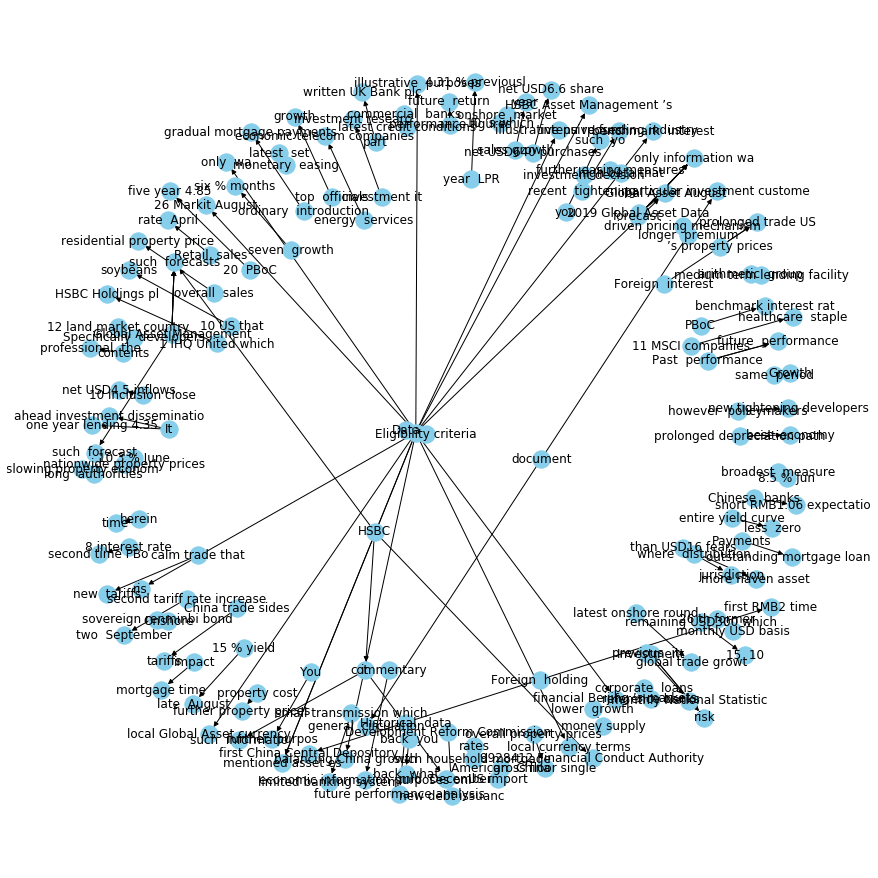

In [54]:
plt.figure(figsize=(12,12))

pos = nx.spring_layout(G)
nx.draw(G, with_labels=True, node_color='skyblue', edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

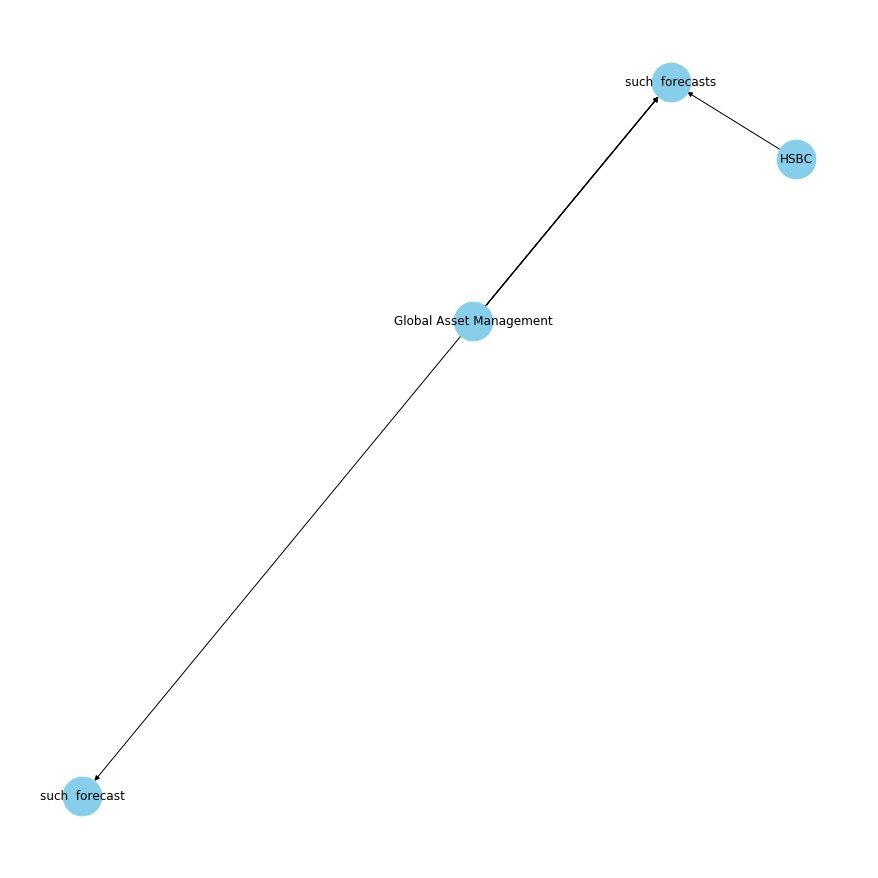

In [55]:
G=nx.from_pandas_edgelist(kg_df[kg_df['edge']=="accepts"], "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k = 0.5) # k regulates the distance between nodes
nx.draw(G, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()